In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# TIF to Numpy Conversion

In [3]:

def tif_to_npy(tif_file, npy_file):
    """
    Convert a .tif file to a .npy array.

    Parameters:
    - tif_file: str, path to the input .tif file.
    - npy_file: str, path to save the output .npy file.
    """
    # Open the .tif file
    with rasterio.open(tif_file) as src:
        # Read the data (assuming single-band raster)
        data = src.read(1)  # Read the first band
        print(f"Data shape: {data.shape}")
        print(f"Data type: {data.dtype}")

    # Save the data as a .npy file
    np.save(npy_file, data)
    print(f"Saved .npy file to: {npy_file}")

# Example usage
tif_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/rasters/Sub-national_rasterized.tif"
npy_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/sub_countries_rasterized.npy"
tif_to_npy(tif_file, npy_file)

Data shape: (16560, 25560)
Data type: int32
Saved .npy file to: /Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/sub_countries_rasterized.npy


Original data shape: (16560, 25560)
Downsampled data shape: (1656, 2556)


/var/folders/sl/lr3h2xdj455ctqq6vn1834000000gn/T/ipykernel_28597/2744036604.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


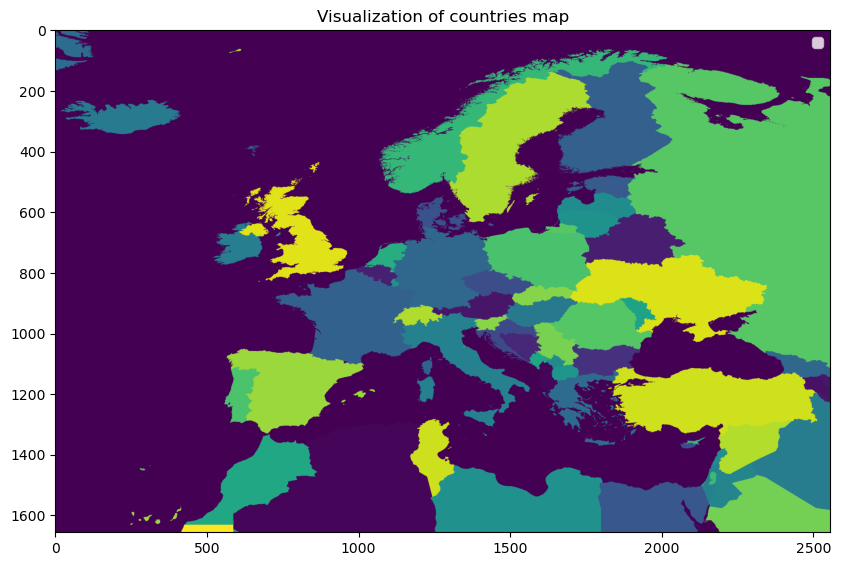

In [4]:

def visualize_npy(npy_file, downsample_factor=10, save_path=None):
    """
    Visualize a large .npy array with optional downsampling.

    Parameters:
    - npy_file: str, path to the .npy file.
    - downsample_factor: int, factor by which to downsample the array.
    """
    # Load the .npy array
    if isinstance(npy_file, str):
        data = np.load(npy_file)
    elif isinstance(npy_file, np.ndarray):
        data = npy_file
    else:
        raise ValueError("Input must be a .npy file or a numpy array.")
    
    print(f"Original data shape: {data.shape}")

    # Downsample the array
    if downsample_factor > 1:
        data = data[::downsample_factor, ::downsample_factor]
        print(f"Downsampled data shape: {data.shape}")

    # Plot the array
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis')
    # plt.colorbar(label='Value')
    plt.legend()
    plt.title("Visualization of countries map")
    # Save the plot if a save path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    plt.show()
   

# Example usage
npy_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/countries_rasterized.npy"
# npy_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_wildfire_Europe.npy"

visualize_npy(npy_file, downsample_factor=10)

# Partition Map Creation

In [5]:
from scipy.ndimage import binary_erosion


In [6]:
countries = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/countries_rasterized.npy")
sub_countries = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/sub_countries_rasterized.npy")
wildfires = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_wildfire_Europe.npy")
elevation = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_elevation_Europe.npy")
wildfires[wildfires > 0] = 1

In [7]:
def create_partition_map(region: np.ndarray, mask: np.ndarray, seed: int = 42) -> np.ndarray:
    """
    Randomly assigns entire region to train (1), val (2), or test (3) partitions
    with proportions 70%, 15%, 15%. Outputs a partition map with the same shape.
    """
    np.random.seed(seed)
    unique_countries = np.unique(region)
    unique_countries = unique_countries[unique_countries != 0]  # Exclude the background (0)
    np.random.shuffle(unique_countries)
    
    n = len(unique_countries)
    train_ids = unique_countries[:int(0.7 * n)]
    val_ids = unique_countries[int(0.7 * n):int(0.85 * n)]
    test_ids = unique_countries[int(0.85 * n):]

    partition_map = np.zeros_like(region, dtype=np.uint8)
    partition_map[np.isin(region, train_ids)] = 1
    partition_map[np.isin(region, val_ids)] = 2
    partition_map[np.isin(region, test_ids)] = 3

    # Apply the mask to the partition map
    mask = np.isnan(mask)
    partition_map[mask] = 0

    return partition_map

In [8]:
def create_partition_map_by_subcountries(countries: np.ndarray, sub_countries: np.ndarray, seed: int = 42) -> np.ndarray:
    """
    For each country, randomly assigns 70% of its sub-country regions to train (1),
    15% to val (2), and 15% to test (3), based on sub-country IDs.

    Returns a partition map with the same shape.
    """
    np.random.seed(seed)
    partition_map = np.zeros_like(countries, dtype=np.uint8)
    unique_countries = np.unique(countries)
    unique_countries = unique_countries[unique_countries != 0]  # Exclude background

    for country_code in unique_countries:
        print(f"Processing country: {country_code}")
        country_mask = (countries == country_code)
        sub_ids = np.unique(sub_countries[country_mask])
        np.random.shuffle(sub_ids)

        n = len(sub_ids)
        n_train = int(0.7 * n)
        n_val = int(0.15 * n)
        n_test = n - n_train - n_val  # Ensure full coverage

        train_subs = sub_ids[:n_train]
        val_subs = sub_ids[n_train:n_train + n_val]
        test_subs = sub_ids[n_train + n_val:]

        partition_map[np.isin(sub_countries, train_subs) & country_mask] = 1
        partition_map[np.isin(sub_countries, val_subs) & country_mask] = 2
        partition_map[np.isin(sub_countries, test_subs) & country_mask] = 3

    return partition_map

In [9]:
def balance_partition_map(partition_map: np.ndarray, labels: np.ndarray, countries: np.ndarray, seed: int = 42) -> np.ndarray:
    """
    Downsamples negative examples within each country to match the number of positive examples.
    Outputs a new partition map where excess negatives are set to 0 (ignored).
    """
    np.random.seed(seed)
    balanced_map = partition_map.copy()
    
    splits = [1]  # Assuming we only want to process the training split
    # splits = [1, 2, 3]  # Uncomment to process all splits
    for split in splits:
        print(f"Processing split {split}...")
        country_ids = np.unique(countries[partition_map == split])
        
        for cid in country_ids:
            print(f"Processing country {cid}...")
            mask = (partition_map == split) & (countries == cid)
            pos_inds = np.argwhere(mask & (labels == 1))
            neg_inds = np.argwhere(mask & (labels == 0))
            
            if len(pos_inds) == 0 or len(neg_inds) == 0:
                # If no positives or no negatives, skip this region
                balanced_map[mask & (labels == 0)] = 0
                continue

            # Downsample negatives to match number of positives
            if len(neg_inds) > len(pos_inds):
                selected_neg_inds = neg_inds[np.random.choice(len(neg_inds), size=len(pos_inds), replace=False)]
                all_neg_mask = np.zeros_like(mask, dtype=bool)
                all_neg_mask[tuple(neg_inds.T)] = True
                keep_mask = np.zeros_like(mask, dtype=bool)
                keep_mask[tuple(selected_neg_inds.T)] = True
                discard_mask = all_neg_mask & ~keep_mask
                balanced_map[discard_mask] = 0
    
    n_train = np.sum(balanced_map == 1)
    n_total = int(n_train/0.7)
    n_val = int(n_total * 0.15)
    n_test = int(n_total * 0.15)
    
    for split in [2, 3]:
        # Randomly sample test and val regions to match n_val and n_test
        print(f"Processing split {split}...")
        indices = np.argwhere(balanced_map == split)
        np.random.shuffle(indices)
        if split == 2:
            discard_indices = indices[n_val:]
        else:
            discard_indices = indices[n_test:]
        discard_mask = np.zeros_like(balanced_map, dtype=bool)
        discard_mask[tuple(discard_indices.T)] = True
        # Set the discarded indices to 0 (ignored)
        balanced_map[discard_mask] = 0
        # Ensure that the number of positives in the test/val set matches the expected count

      
    print(f"Final counts: Train: {np.sum(balanced_map == 1)}, Val: {np.sum(balanced_map == 2)}, Test: {np.sum(balanced_map == 3)}")


    return balanced_map

In [10]:
def clean_partition_map(partition_map: np.ndarray, countries: np.ndarray, countries_to_remove: np.ndarray) -> np.ndarray:
    """
    Removes specified countries from the partition map by setting their cells to 0.
    """
    cleaned_map = partition_map.copy()
    mask = np.isin(countries, countries_to_remove)
    cleaned_map[mask] = 0
    return cleaned_map

In [11]:
def get_partition_stats(partition_map: np.ndarray, labels: np.ndarray, countries: np.ndarray) -> dict:
    """
    Returns a dictionary with detailed statistics for each partition (train=1, val=2, test=3).
    Includes counts of total, positive, and negative samples, class ratio, and country distribution.
    """
    stats = {}
    for split in [1, 2, 3]:
        mask = (partition_map == split)
        total = np.sum(mask)
        positives = np.sum((labels == 1) & mask)
        negatives = np.sum((labels == 0) & mask)
        unique_countries, counts = np.unique(countries[mask], return_counts=True)
        country_distribution = dict(zip(unique_countries.tolist(), counts.tolist()))
        stats[split] = {
            'split_name': {1: 'Train', 2: 'Validation', 3: 'Test'}[split],
            'total_samples': int(total),
            'positives': int(positives),
            'negatives': int(negatives),
            'positive_ratio (%)': round(100 * positives / total, 2) if total > 0 else 0.0,
            'negative_ratio (%)': round(100 * negatives / total, 2) if total > 0 else 0.0,
            'class_balance': f"{positives}:{negatives}",
            'num_countries': len(unique_countries),
            'country_distribution': country_distribution
        }
    return stats

In [12]:
def get_country_split_stats(partition_map, countries):
    """
    For each country, calculates the percentage of its total cells that fall into
    train (1), val (2), and test (3) partitions.

    Returns:
        Dictionary structured as:
        {
            country_code: {
                'train_pct': float,
                'val_pct': float,
                'test_pct': float
            },
            ...
        }
    """
    import numpy as np

    stats = {}
    unique_countries = np.unique(countries)
    unique_countries = unique_countries[unique_countries != 0]  # exclude background

    last_country = unique_countries[-1]
    for country_code in unique_countries:
        print(f"Processing country: {country_code}/{last_country}")
        country_mask = (countries == country_code)

        total_cells = np.sum(country_mask)
        train_cells = np.sum((partition_map == 1) & country_mask)
        val_cells = np.sum((partition_map == 2) & country_mask)
        test_cells = np.sum((partition_map == 3) & country_mask)

        if total_cells == 0:
            stats[country_code] = {'train_pct': 0.0, 'val_pct': 0.0, 'test_pct': 0.0}
        else:
            stats[country_code] = {
                'train_pct': round(100 * train_cells / total_cells, 2),
                'val_pct': round(100 * val_cells / total_cells, 2),
                'test_pct': round(100 * test_cells / total_cells, 2)
            }

    return stats

In [13]:
def erode_partition_borders(partition_map: np.ndarray, kernel_size: int = 5) -> np.ndarray:
    """
    Erodes the borders between partition regions to avoid leakage during patch sampling.
    Returns a new map where border-adjacent cells are set to 0.
    
    Args:
        partition_map (np.ndarray): Array with values 1 (train), 2 (val), 3 (test)
        kernel_size (int): Size of patch to be used for erosion. Default is 5.)
    
    Returns:
        np.ndarray: Eroded partition map with border cells removed (set to 0)
    """
    eroded_map = np.zeros_like(partition_map, dtype=np.uint8)+1
    structure = np.ones((kernel_size, kernel_size), dtype=bool)
    ocean_mask = (partition_map == 0)
    for label in [1, 2, 3]:
        print(f"Eroding label {label}...")
        region_mask = ((partition_map == label) | (partition_map == 0))
        eroded_mask = binary_erosion(region_mask, structure=structure)
        eroded_map[eroded_mask] = label
    eroded_map[ocean_mask] = 0
    # Set the borders to 0
    for label in [1, 2, 3]:
        border_mask = (partition_map == label) & (eroded_map != label)
        eroded_map[border_mask] = 4
    return eroded_map

In [ ]:
from scipy.ndimage import binary_erosion

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


import cartopy.crs as ccrs
import cartopy.feature as cfeature



def plot_npy_arrays(npy_files, npy_names, partition_map=False, debug_nans=False, log=False, downsample_factor=1, save_path=None):
    """
    Plots the data from npy files on a map with the correct coordinates.

    Parameters:
    npy_files (list): List of file paths to the npy files.
    npy_names (list): List of names corresponding to the npy files.
    extents (list): List of extents (geographical bounds) for each npy file.

    Returns:
    None
    """
    extent = (-25.0001389, 45.9998611,  27.0001389, 73.0001389)

    if isinstance(npy_files, np.ndarray):
        npy_files = [npy_files]
        npy_names = [npy_names]
    
    for i, npy_file in enumerate(npy_files):

        name = npy_names[i]

        # Create a subplot with PlateCarree projection
        fig, axs = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

        print(npy_names[i])

        if isinstance(npy_file, str):
            npy_data = np.load(npy_file)
            print("File loaded")
        elif isinstance(npy_file, np.ndarray):
            npy_data = npy_file
            print("Array loaded")


        if downsample_factor > 1:
            npy_data = npy_data[::downsample_factor, ::downsample_factor]
            print(f"Downsampled data shape: {npy_data.shape}")
        
        if log:
            npy_data = np.log1p(npy_data)
      
        if debug_nans:
            # set everything to 0 except for NaNs
            npy_data[~np.isnan(npy_data)] = 0
            npy_data[np.isnan(npy_data)] = 1

        # Normalize the colorbar to the range [0, 1] (adjust as needed)
        # norm = Normalize(vmin=0, vmax=np.max(npy_data))

        # Plot the data on the subplot grid
        labels = [ 'Ignored', 'Train', 'Validation', 'Test']
        colors = plt.cm.viridis(np.linspace(0, 1, len(labels))) 
        colors[0] = (1, 1, 1, 1)  # Set the first color to transparent
        cmap = mcolors.ListedColormap(colors)


        im = axs.imshow(npy_data, cmap=cmap, extent=extent)
        print("image created")

        # Set title for each subplot
        axs.set_title(f'European {name} Map', fontsize=16)

        # Set longitude tick labels
        axs.set_xticks(np.arange(extent[0], extent[1] + 1, 5), crs=ccrs.PlateCarree())
        axs.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}°'))

        # Set latitude tick labels
        axs.set_yticks(np.arange(extent[2], extent[3] + 1, 5), crs=ccrs.PlateCarree())
        axs.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}°'))

        axs.set_xlabel('Longitude')
        axs.set_ylabel('Latitude')

        # Add coastlines and country borders
        axs.add_feature(cfeature.COASTLINE, linewidth=0.1, edgecolor='black')
        axs.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.1)
        axs.add_feature(cfeature.LAND, facecolor='#FFEB3B', alpha=0.1)
        axs.add_feature(cfeature.OCEAN, facecolor='#A6CAE0')


        # # crop the map to the extent
        # croped_extent = (-5, 10, 40, 52)
        # axs.set_extent(croped_extent, crs=ccrs.PlateCarree())


        # Adjust layout for better spacing
        plt.tight_layout()
        # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05)   
    
        # Add a colorbar for all subplots
        if not partition_map:
            cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
            cbar.set_label(f'{name} counts', fontsize=16)
            if log:
                cbar.set_label(f'log {name} counts', fontsize=16)

            cbar.ax.tick_params(labelsize=12) 
        else:
            

            patches =[mpatches.Patch(color=color,label=labels[i]) for i, color in enumerate(colors)]
            fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.53, 0.15),
            fancybox=True, ncol=4)



        # # Set the colorbar ticks and labels
        # cbar.set_ticks(np.arange(0, 1.1, 0.1))  # Ticks from 0 to 1 with 0.1 increments
        # cbar.set_ticklabels([f'{i:.1f}' for i in np.arange(0, 1.1, 0.1)])

 

        # Save the plot
        if save_path is not None:
            plt.savefig(save_path, dpi=1000, bbox_inches='tight')

In [12]:
partition_map = create_partition_map(sub_countries, elevation, seed=43)

Partition
Array loaded
Downsampled data shape: (1656, 2556)
image created


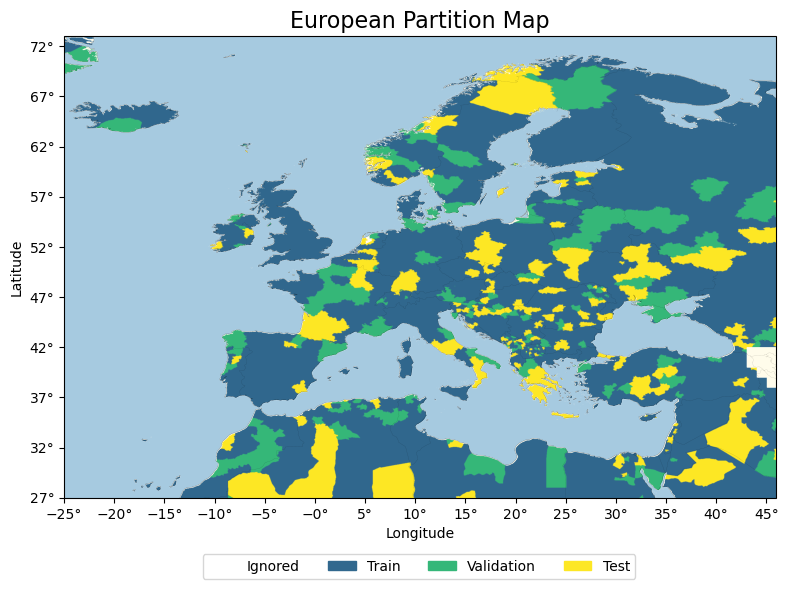

In [62]:
plot_npy_arrays(partition_map, "Partition", partition_map=True, downsample_factor=10)

In [48]:
(partition_map!=0)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [18]:
eroded_map = erode_partition_borders(partition_map, kernel_size=5)

Eroding label 1...
Eroding label 2...
Eroding label 3...


Original data shape: (16560, 25560)


/var/folders/sl/lr3h2xdj455ctqq6vn1834000000gn/T/ipykernel_51818/3205929282.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Plot saved to: /Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/eroded_partition_map_sub_countries.png


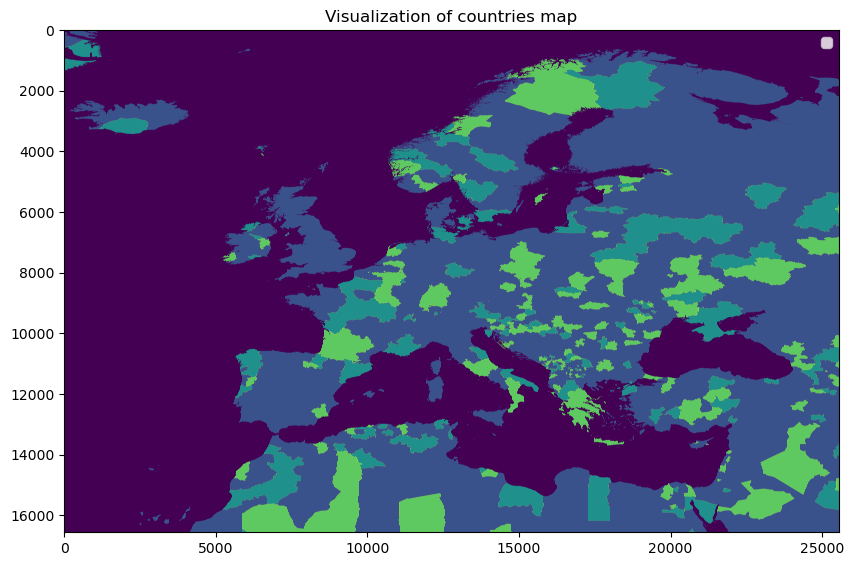

In [19]:
visualize_npy(eroded_map, downsample_factor=1, save_path="/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/eroded_partition_map_sub_countries.png")

In [21]:
final_map = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/final_partition_map.npy")

In [22]:
get_partition_stats(final_map, wildfires, countries)

{1: {'split_name': 'Train',
  'total_samples': 18229845,
  'positives': 9537380,
  'negatives': 8692465,
  'positive_ratio (%)': 52.32,
  'negative_ratio (%)': 47.68,
  'class_balance': '9537380:8692465',
  'num_countries': 55,
  'country_distribution': {3: 51644,
   4: 362678,
   15: 4222,
   21: 231376,
   22: 1530,
   29: 63820,
   36: 300426,
   57: 45256,
   60: 6958,
   61: 9082,
   63: 22342,
   68: 70538,
   72: 6398,
   77: 11998,
   78: 175745,
   84: 6764,
   85: 11877,
   88: 187690,
   102: 71906,
   106: 37406,
   107: 436420,
   108: 10057,
   110: 7352,
   111: 353486,
   115: 2596,
   119: 9578,
   123: 19281,
   124: 1130,
   127: 3030,
   129: 13789,
   130: 106,
   132: 34616,
   146: 86726,
   149: 28393,
   151: 26481,
   157: 36,
   166: 2030,
   168: 4814,
   172: 1158,
   180: 44104,
   181: 395264,
   186: 611450,
   187: 7333634,
   199: 68914,
   201: 184899,
   206: 9822,
   207: 1128,
   214: 600939,
   221: 3450,
   222: 496,
   223: 89026,
   233: 26162,

Train
Array loaded
Downsampled data shape: (1656, 2556)
image created


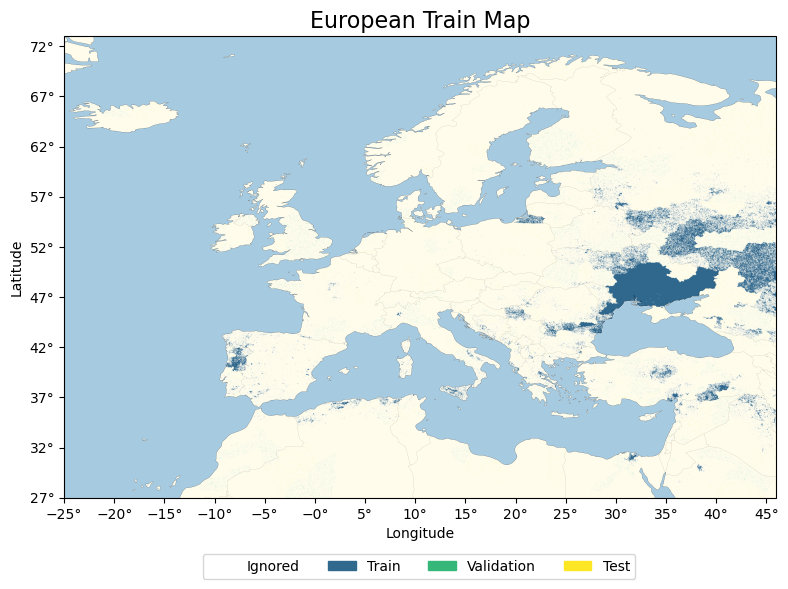

In [23]:
plot_npy_arrays(final_map, "Train", partition_map=True, downsample_factor=10)

In [26]:
np.unique(final_map, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8),
 array([397230965,  18229845,   3906395,   3906395]))

# Normalize npy arrays

In [112]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_npy(npy_file_path: str, output_file_path: str) -> None:
    """
    Normalizes the values in a .npy file to the range [0, 1] using MinMaxScaler.
    Saves the normalized array to the specified output path.

    Args:
        npy_file_path (str): Path to the input .npy file.
        output_file_path (str): Path to save the normalized .npy file.
    """
    # Load the array
    data = np.load(npy_file_path)

    # Reshape for MinMaxScaler
    reshaped_data = data.reshape(-1, 1)

    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(reshaped_data)

    # Reshape back to original shape
    normalized_data = normalized_data.reshape(data.shape)

    # Save the normalized array
    np.save(output_file_path, normalized_data)

In [113]:
normalize_npy("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_elevation_Europe.npy", "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_elevation_Europe_normalized.npy")

In [115]:
wildfires.dtype

dtype('float64')

Normalized Elevation
Array loaded
Downsampled data shape: (1656, 2556)
image created


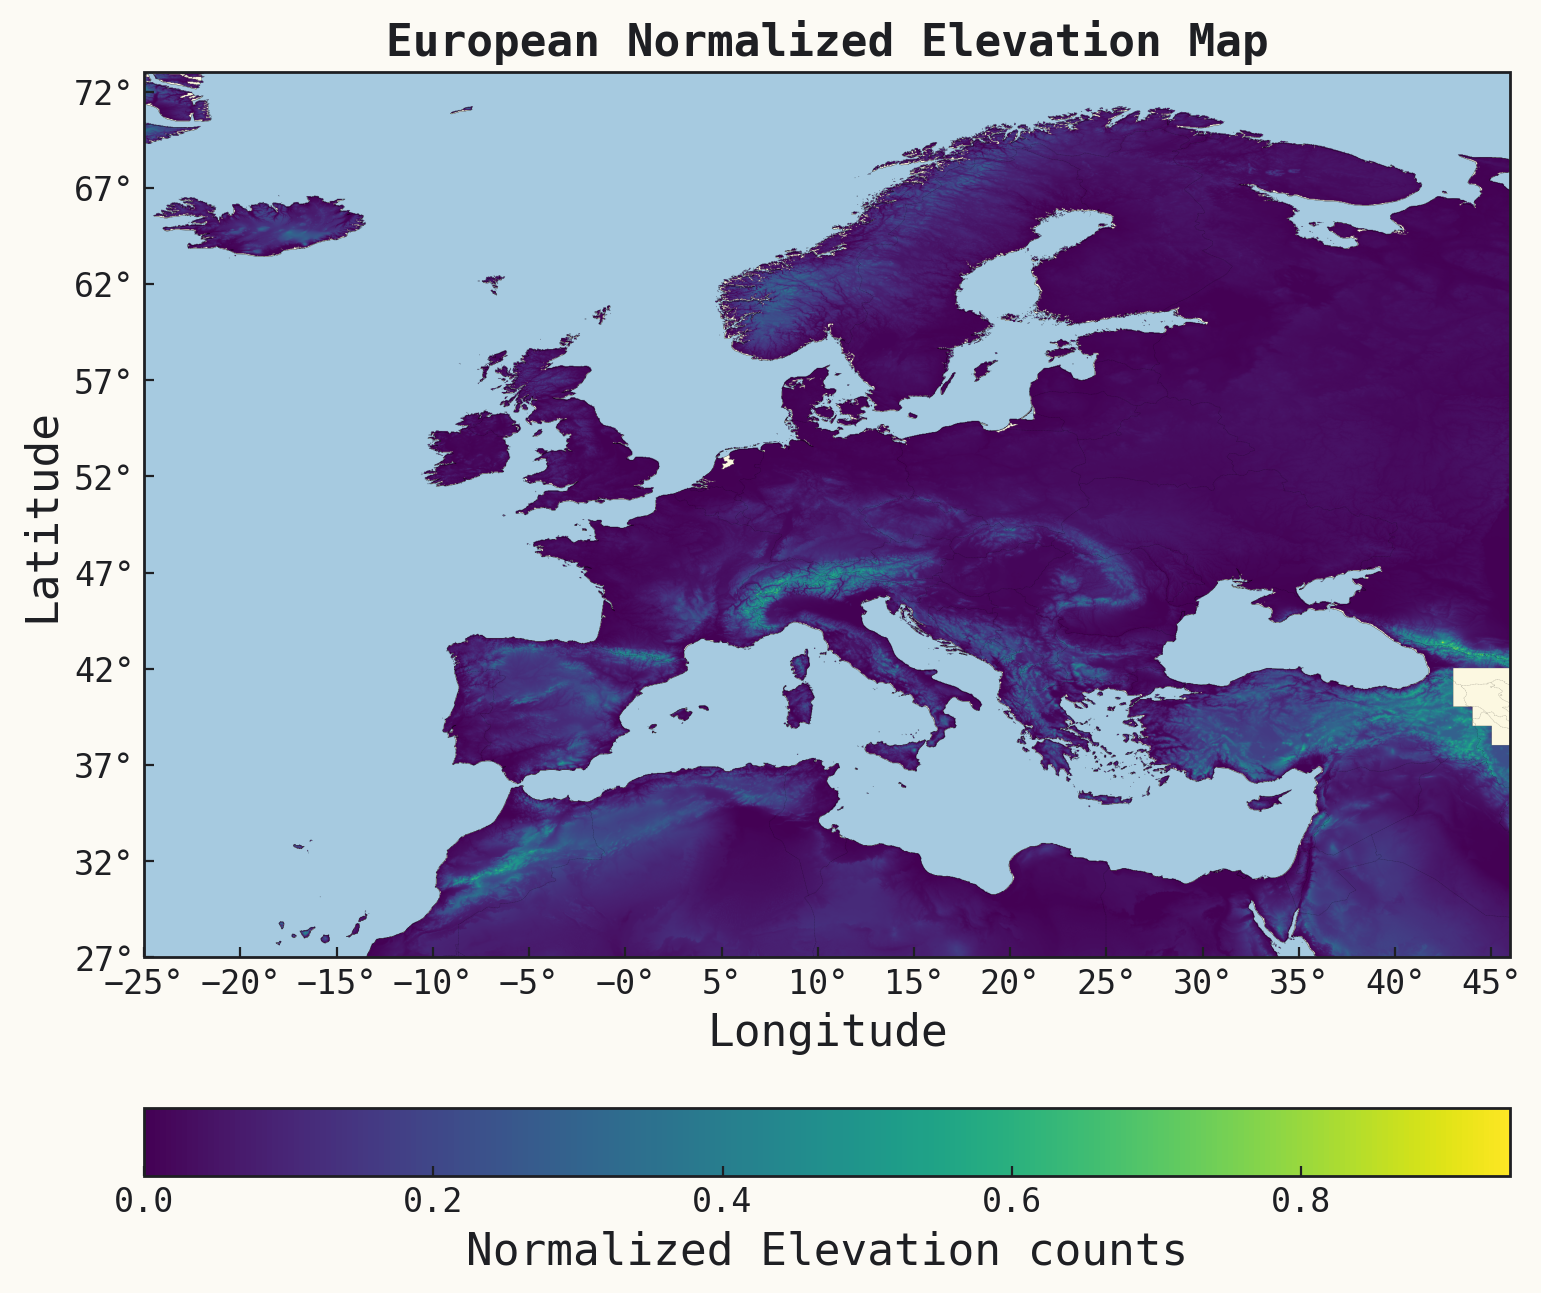

In [114]:
normalized = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_elevation_Europe_normalized.npy")
plot_npy_arrays(normalized, "Normalized Elevation", downsample_factor=10)